In [1]:
#!pip install fairlearn

In [13]:
# Install required libraries if needed
# pip install fairlearn scikit-learn pandas

import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from fairlearn.reductions import ExponentiatedGradient, DemographicParity, EqualizedOdds
from fairlearn.metrics import (
    demographic_parity_difference,
    equalized_odds_difference,
    MetricFrame,
    selection_rate,
    true_positive_rate
)

# Set options to display all columns in a dataframe and prevent wrapping

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', 1000)
pd.set_option('display.expand_frame_repr', False) # Prevents breaking the output into multiple pages
pd.set_option('display.precision', 4)



def get_metrics_frame(y_true, y_pred, s_test):

  """
  Calculates overall accuracy, accuracy for class 1, accuracy for class 0, selection rate, and true positive rate.

  Parameters:
  y_true (array-like): The true labels.
  y_pred (array-like): The predicted labels.
  s_test (array-like): The sensitive features.

  Returns:
  metric_frame (fairlearn.metrics.MetricFrame): A MetricFrame object containing the calculated metrics.
  """

  metric_frame = MetricFrame(
      metrics={
          'accuracy': lambda y_true, y_pred: (y_true == y_pred).mean(),
          'accuracy_class1': lambda y_true, y_pred: (y_pred[y_true == 1] == 1).mean(),
          'accuracy_class0': lambda y_true, y_pred: (y_pred[y_true == 0] == 0).mean(),
          'selection_rate': selection_rate,
          'true_positive_rate': true_positive_rate,
      },
      y_true=y_true,
      y_pred=y_pred,
      sensitive_features=s_test
  )
  return metric_frame

  # 1. Load the dataset
data = fetch_openml(data_id=1590, as_frame=True)  # Adult dataset
df = data.frame



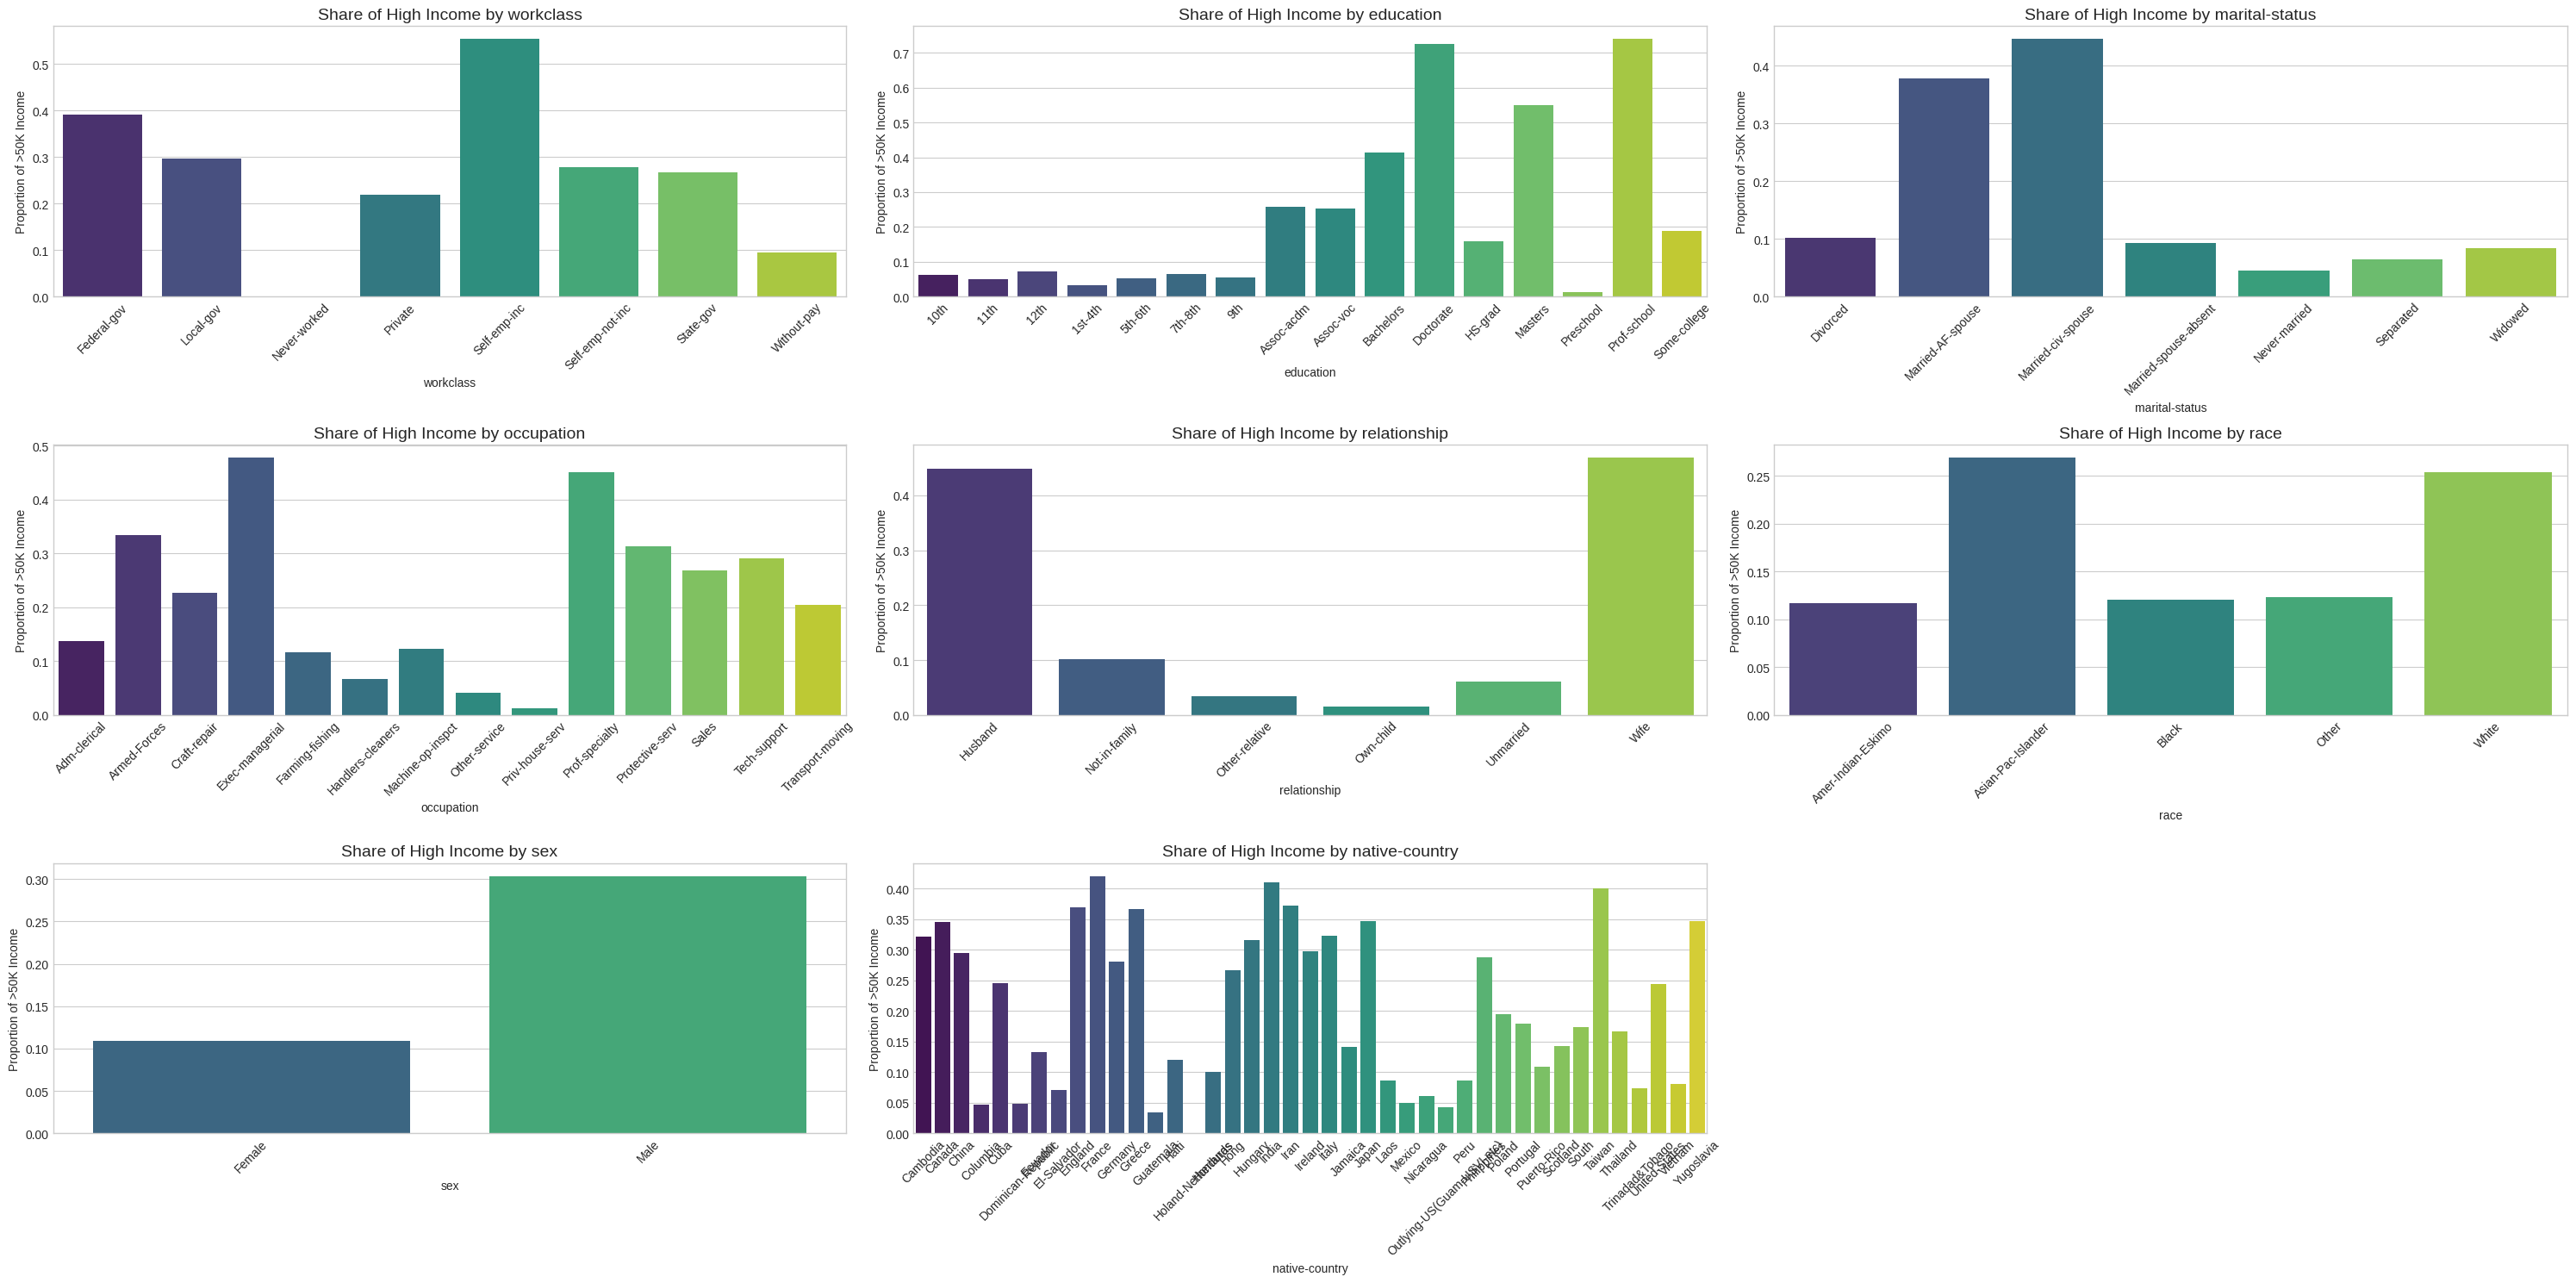

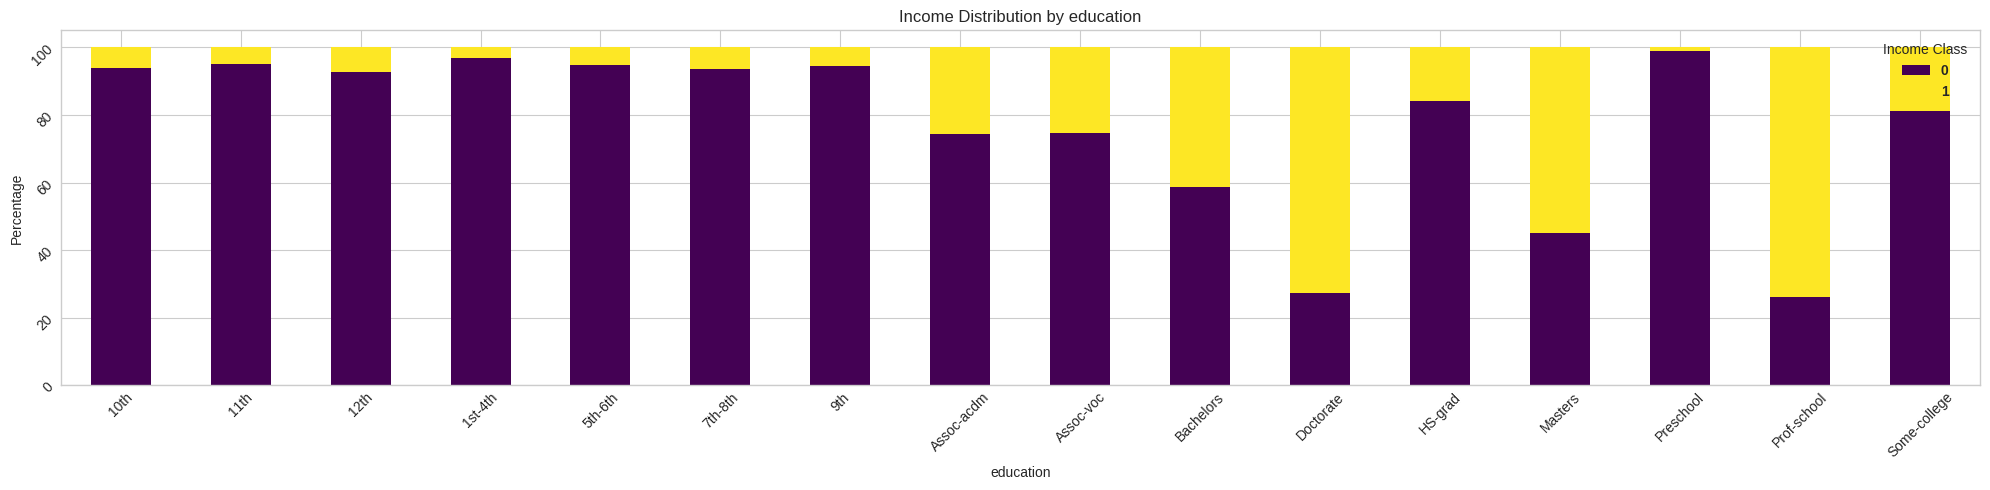

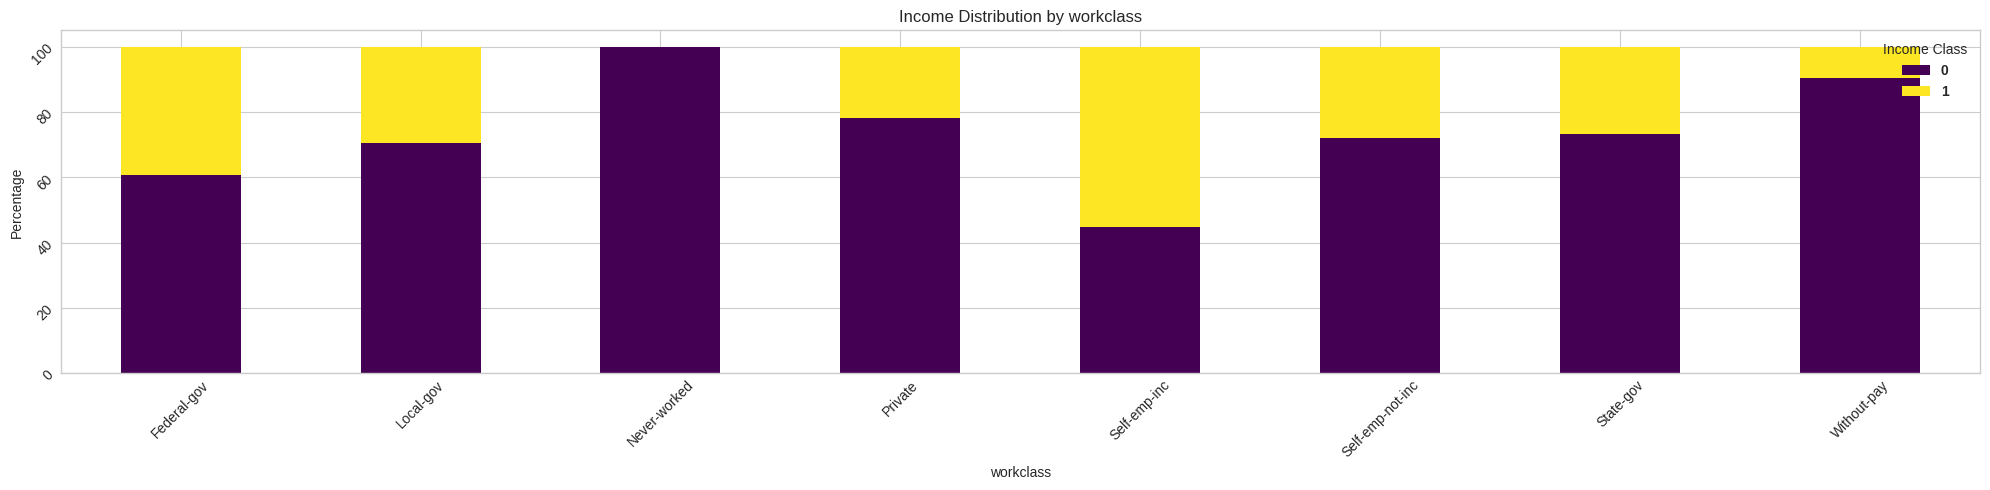

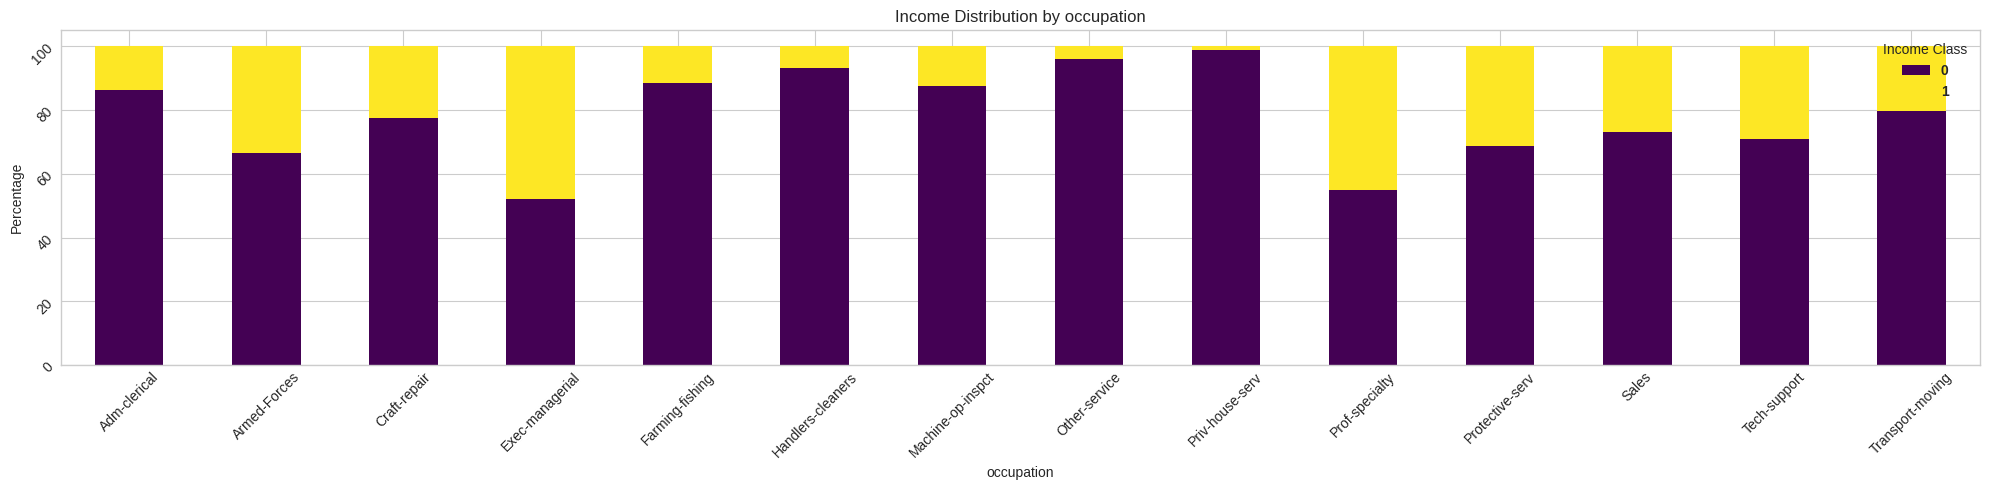

In [16]:
########################################################################################
################################ OPTIONAL PLOTS ########################################



df["higher_income"]  = (df["class"] == ">50K").astype(int)
# Identify numerical columns
numerical_cols = df.select_dtypes(include=["int64", "float64"]).columns.tolist()
# Identify categorical columns
categorical_cols = df.select_dtypes(include=["category", "object"]).columns.tolist()
categorical_cols = [col for col in categorical_cols if col not in ["class"]]  # exclude old target

# Plot relationships between categorical features and higher_income
plt.style.use("seaborn-v0_8-whitegrid")
n_cols = 3
n_rows = (len(categorical_cols) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(30, 5 * n_rows))
axes = axes.flatten()

for i, col in enumerate(categorical_cols):
    # Compute mean income rate per category
    income_rate = (df.groupby(col, observed=False)["higher_income"].mean().sort_values(ascending=False).reset_index())  # <-- ensures DataFrame)

    sns.barplot(data=income_rate, x=col, y="higher_income", hue=col, ax=axes[i], palette="viridis", legend=False)

    axes[i].set_title(f"Share of High Income by {col}", fontsize=14)
    axes[i].set_ylabel("Proportion of >50K Income")
    axes[i].set_xlabel(col)
    axes[i].tick_params(axis='x', rotation=45)

# Remove empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# (Optional) Show stacked percentage plots for top 3 most correlated categorical features
top_features = []
for col in categorical_cols:
    mean_diff = abs(df.groupby(col, observed=False)["higher_income"].mean().max() - df.groupby(col, observed=False)["higher_income"].mean().min())
    top_features.append((col, mean_diff))
top_features = [x[0] for x in sorted(top_features, key=lambda x: x[1], reverse=True)[:3]]

for col in top_features:

    cross_tab = pd.crosstab(df[col], df["higher_income"], normalize='index') * 100
    # Plot stacked bar
    ax = cross_tab.plot(
        kind='bar',
        stacked=True,
        colormap='viridis',
        figsize=(20, 5)
    )

    # Title and labels
    ax.set_title(f"Income Distribution by {col}")
    ax.set_ylabel("Percentage")
    ax.set_xlabel(col)
    ax.tick_params(rotation=45)

    # Use ax.legend() with handles from the plot
    ax.legend(
        title="Income Class",
        loc='upper right',
        prop={'weight': 'bold'}
    )

    plt.tight_layout()
    plt.show()


In [17]:


########################################################################################
######################## FAIRNESS MITIGATION & EVALUATION ##############################


# 2. Prepare data
X = df.drop(columns=["class","higher_income"]) # Remove collinear features to the target feature `higher_income`
y = df['higher_income']
sensitive_feature = df["sex"]  # protected attribute

X = pd.get_dummies(X, drop_first=True)

X_train, X_test, y_train, y_test, s_train, s_test = train_test_split(
    X, y, sensitive_feature, test_size=0.3, random_state=42
)

# 3. Train an unconstrained (baseline) model
scaler = StandardScaler(with_mean=False)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

base_model = LogisticRegression(max_iter=200)
base_model.fit(X_train_scaled, y_train)
y_pred = base_model.predict(X_test_scaled)

# Measure baseline fairness
dp_diff_before = demographic_parity_difference(y_test, y_pred, sensitive_features=s_test)
eo_diff_before = equalized_odds_difference(y_test, y_pred, sensitive_features=s_test)

print(f"Baseline Demographic Parity Difference: {dp_diff_before:.3f}")
print(f"Baseline Equalized Odds Difference: {eo_diff_before:.3f}")


def apply_fairness_mitigation_and_evaluate(constraint_type):

  """
  Apply fairness mitigation and calculate metrics before and after mitigation

  Parameters:
  ------------
  constraint_type : fairlearn.reductions.Constrain

  Returns:
  --------
  None

  """

  # 4. Apply fairness mitigation with Exponentiated Gradient
  fair_model = ExponentiatedGradient(
      estimator=LogisticRegression(max_iter=200),
      constraints=constraint_type,  # DemographicParity() or EqualizedOdds()
      eps=0.01
  )

  fair_model.fit(X_train_scaled, y_train, sensitive_features=s_train)

  # 5. Evaluate the fair model
  y_pred_fair = fair_model.predict(X_test_scaled)

  dp_diff_after = demographic_parity_difference(y_test, y_pred_fair, sensitive_features=s_test)
  eo_diff_after = equalized_odds_difference(y_test, y_pred_fair, sensitive_features=s_test)

  # Accuracy comparison
  accuracy_before = (y_pred == y_test).mean()
  accuracy_after = (y_pred_fair == y_test).mean()

  print("\n=== Fairness Comparison ===")
  print(f"Accuracy before mitigation: {accuracy_before:.3f}")
  print(f"Accuracy after mitigation:  {accuracy_after:.3f}")
  print(f"Demographic Parity Diff before: {dp_diff_before:.3f}")
  print(f"Demographic Parity Diff after:  {dp_diff_after:.3f}")
  print(f"Equalized Odds Diff before:    {eo_diff_before:.3f}")
  print(f"Equalized Odds Diff after:     {eo_diff_after:.3f}")

  # 6. Inspect performance by group

  metric_frame_before = get_metrics_frame(y_test, y_pred, s_test)
  print("\nMetrics by group before mitigation:")
  print(metric_frame_before.by_group)


  metric_frame_after = get_metrics_frame(y_test, y_pred_fair, s_test)
  print("\nMetrics by group after mitigation:")
  print(metric_frame_after.by_group)


Baseline Demographic Parity Difference: 0.181
Baseline Equalized Odds Difference: 0.093


In [18]:
apply_fairness_mitigation_and_evaluate(DemographicParity())


=== Fairness Comparison ===
Accuracy before mitigation: 0.857
Accuracy after mitigation:  0.840
Demographic Parity Diff before: 0.181
Demographic Parity Diff after:  0.019
Equalized Odds Diff before:    0.093
Equalized Odds Diff after:     0.296

Metrics by group before mitigation:
        accuracy  accuracy_class1  accuracy_class0  selection_rate  true_positive_rate
sex                                                                                   
Female    0.9340           0.5267           0.9814          0.0715              0.5267
Male      0.8188           0.6196           0.9032          0.2523              0.6196

Metrics by group after mitigation:
        accuracy  accuracy_class1  accuracy_class0  selection_rate  true_positive_rate
sex                                                                                   
Female    0.9015           0.7663           0.9172          0.1540              0.7663
Male      0.8092           0.4707           0.9525          0.1733     

In [19]:
apply_fairness_mitigation_and_evaluate(EqualizedOdds())


=== Fairness Comparison ===
Accuracy before mitigation: 0.857
Accuracy after mitigation:  0.847
Demographic Parity Diff before: 0.181
Demographic Parity Diff after:  0.103
Equalized Odds Diff before:    0.093
Equalized Odds Diff after:     0.021

Metrics by group before mitigation:
        accuracy  accuracy_class1  accuracy_class0  selection_rate  true_positive_rate
sex                                                                                   
Female    0.9340           0.5267           0.9814          0.0715              0.5267
Male      0.8188           0.6196           0.9032          0.2523              0.6196

Metrics by group after mitigation:
        accuracy  accuracy_class1  accuracy_class0  selection_rate  true_positive_rate
sex                                                                                   
Female    0.9074           0.5644           0.9473           0.106              0.5644
Male      0.8166           0.5431           0.9323           0.209     